# HRTFs: Post-Processing and Normalization
*Fabian Brinkmann*<br>  
*Audio Communication Group, Technische Universität Berlin*<br>  
*Contact: fabian.brinkmann@tu-berlin.de*

The task of this notebook is post-process raw data from sweep-based acoustic measurement to obtain HRTFs in a first step, and to normalize the HRTFs in a second step.

**Duration:** 180-360 Minutes

**Requirements:** Basic knowledge of HRTFs and coordinate conventions. Good knowledge of digital signal processing and pyfar.

**References**<br>  
[1] H. Møller, “Fundamentals of binaural technology,” Appl. Acoust., vol. 36, pp. 171–218, 1992, doi: [10.1016/0003-682x(92)90046-u](https://doi.org/10.1016/0003-682x(92)90046-u).  
[2] H. Bahu et al., “Towards improved consistency between databases of head-related transfer functions,” J. Audio Eng. Soc., 2025.  
[3] F. Brinkmann et al., “A High Resolution and Full-Spherical Head-Related Transfer Function Database for Different Head-Above-Torso Orientations,” J. Audio Eng. Soc., vol. 65, no. 10, pp. 841–848, Oct. 2017, doi: [10.17743/jaes.2017.0033](https://dio.org/10.17743/jaes.2017.0033).  
[4] B. Xie, “On the low frequency characteristics of head-related transfer function,” Chinese J. Acoust., vol. 28, no. 2, pp. 1–13, 2009.  
[5] B. Bernschütz, “A spherical far field HRIR/HRTF compilation of the Neumann KU 100,” in AIA-DAGA 2013, International Conference on Acoustics, Merano, Italy, Mar. 2013, pp. 592–595.  
[6] R. O. Duda and W. L. Martens, “Range dependence of the response of a spherical head model,” J. Acoust. Soc. Am., vol. 104, no. 5, pp. 3048–3058, 1998.  

**Dependencies**<br>  
`pip install pyfar>=0.7 pooch nbgrader ipykernel watermark`

In [1]:
import pyfar as pf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import pooch
import os
# %matplotlib ipympl

## 1. Load example data

The following downloads the data for this task: recorded sine sweeps for five source positions from the FABIAN HRTF database [3].

In [12]:
# adjust this path to your needs. Using `None` will download the file to your
# system cash.
path = None

# Leave this as it is: This is the URL from which the data will be downloaded
# and a hash for checking if the download worked.
url = 'https://github.com/pyfar/files/raw/refs/heads/main/education/VAR_TUB/hrtf_post_processing_and_normalization.far?download='
hash = '1f4e7ad698ce65c1e359d914918fa9f4f81ca611eb9812243b55798fb2462732'

file = pooch.retrieve(
    url, hash, fname='hrtf_post_processing_and_normalization.far', path=path)

This reads the data as pyfar Signal and Coordinate objects.

In [14]:
# read data
data = pf.io.read(file)

# sweeps recorded at the ears and corresponding microphone positions
ear_pressure = data['ear_pressure']
ear_positions = data['ear_positions']

# sweeps recorded at the center of the loudspeaker array with the dummy
# being absent and the corresponding position
reference_pressure = data['reference_pressure']
reference_position = data['reference_position']

# source positions for with the recorded sweeps were taken
source_positions = data['source_positions']

Next, we download and import Python code for a spherical head model that will be used in the normalization process

In [5]:
# Leave this as it is: This is the URL from which the data will be downloaded
url = 'https://github.com/pyfar/open-educational-resources/tree/main/docs/oer/courses/Virtual_Acoustic_Reality_TUB/hrtf_processing/spherical_head.py?raw=true'
hash = '7e30984c122dbc6df2c76ee073c8c6bc4c3d750ddb10186cd547ab5c18ee23c6'

# Download to the directory of this notebook for importing
_ = pooch.retrieve(
    url, hash, fname='spherical_head.py', path=os.getcwd())

from spherical_head import spherical_head

ValueError: SHA256 hash of downloaded file (spherical_head.py) does not match the known hash: expected 7e30984c122dbc6df2c76ee073c8c6bc4c3d750ddb10186cd547ab5c18ee23c6 but got 29e583ab47dcca8ab4379094f377a0123f1175dc97ed13af3f8080360a863ba9. Deleted download for safety. The downloaded file may have been corrupted or the known hash may be outdated.

## 2. Get familiar with the data

It is always good to get to know the data you are working with. Start by plotting the scene geometry defined by the positions loaded as pyfar coordinate objects above. You should know the following:

- For how many and which source position are the data available?
- Where were the microphones located during the HRIR and reference measurements?

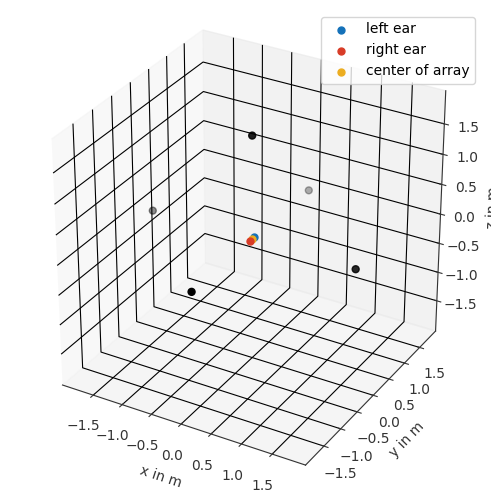

Source positions:
0:   0 deg. azimuth,  0 deg. elevation, 1.7 m radius, 
1:  90 deg. azimuth,  0 deg. elevation, 1.7 m radius, 
2: 180 deg. azimuth,  0 deg. elevation, 1.7 m radius, 
3: 270 deg. azimuth,  0 deg. elevation, 1.7 m radius, 
4:   0 deg. azimuth, 90 deg. elevation, 1.7 m radius, 


In [6]:
### BEGIN SOLUTION
# ignore warning when plotting a single coordinate point
with np.errstate(divide='ignore', invalid='ignore'):
    ax = source_positions.show(color='k')
    ear_positions[0].show(label='left ear', ax=ax)
    ear_positions[1].show(label='right ear', ax=ax)
    reference_position.show(label='center of array', ax=ax)
ax.legend()
plt.show()

print('Source positions:')
for n in range(source_positions.csize):
    pos = pf.rad2deg(source_positions[n].spherical_elevation).flatten()
    print(f'{n}: {pos[0]:3.0f} deg. azimuth, {pos[1]:2.0f} deg. elevation, {pos[2]:1.1f} m radius, ')
### END SOLUTION

Plot a recorded sweeps and use [pyfar plot shortcuts](https://pyfar.readthedocs.io/en/stable/modules/pyfar.plot.html#pyfar.plot.shortcuts) to inspect the sweep in the time and frequency domain.

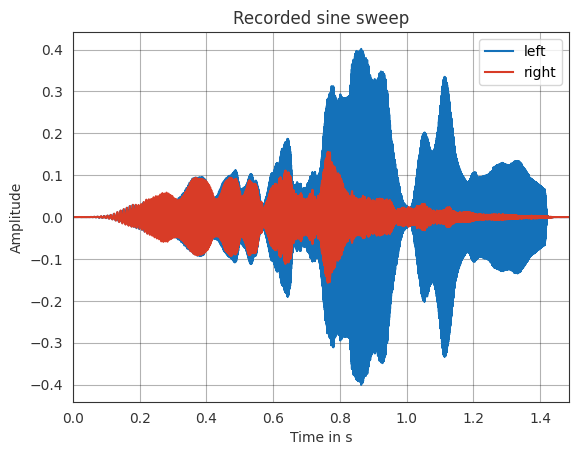

In [7]:
### BEGIN SOLUTION
data = ear_pressure[1]
plt.figure()
ax = pf.plot.time(data, label=['left', 'right'])
ax.legend()
ax.set_title('Recorded sine sweep')
plt.show()
### END SOLUTION

Play back the same sweep via headphones.

In [8]:
### BEGIN SOLUTION
sweep_player = Audio(
    data.time, rate=data.sampling_rate)
display('Recorded sweep:')
display(sweep_player)
### END SOLUTION

'Recorded sweep:'

## 3. Deconvolution

The first step is to obtain the raw HRTF by means of deconvolution, i.e.,

$$H = \frac{P_\text{ear}}{P_\text{reference}} \, \mathrm{e}^{-\mathrm{j}\omega\tau} = P_\text{ear} \, \frac{1}{P_\text{reference}} \, \mathrm{e}^{-\mathrm{j}\omega\tau}$$

Where $H$ is the HRTF (complex spectrum) and $\tau$ a delay to force causality. You will soon see, why this is required.

**NOTE:** From now on, you should always visualize the processing steps for all data to inspecting if things went according to plan.

### a) Invert reference

Note that regularization is often used to compute the inverse $1/P_\text{reference}$ to avoid excessive gains when inverting band-limited signals. This is done to not boost out-of-band noise. You can realize this and most other processing steps can be done with the `pyfar.dsp` module.

The regularization will later act on the HRIRs as a band pass. Bahu et al. [2, Sec. 1.1] suggest to low-pass at 18 kHz to normalize measurements across different datasets. If measurements are valid beyond this range, it does not harm to increase the low-pass frequency.

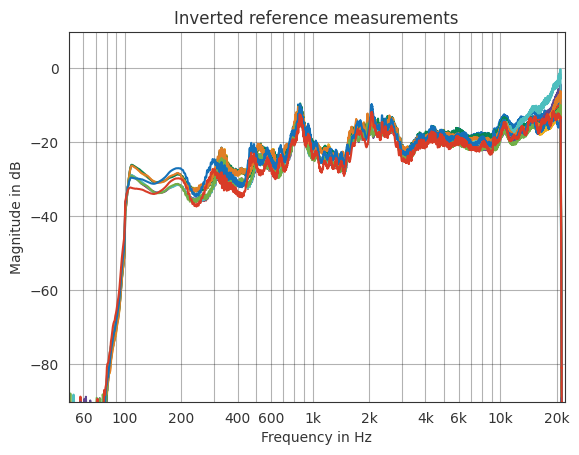

In [9]:
# sweep inversion
### BEGIN SOLUTION
reference_pressure_inverted = pf.dsp.regularized_spectrum_inversion(
    reference_pressure, frequency_range=(110, 21000))

plt.figure()
ax = pf.plot.freq(reference_pressure_inverted)
ax.set_title('Inverted reference measurements')
ax.set_xlim(50, 22050)
plt.show()
### END SOLUTION

### b) Deconvolve

Next, perform a frequency domain multiplication of the sweeps recorded at the ear channels with the inverse computed above.

In [ ]:
### BEGIN SOLUTION
hrir_deconvolved = ear_pressure * reference_pressure_inverted

plt.figure()
ax = pf.plot.time(hrir_deconvolved, dB=True)
ax.set_title('Deconcolved HRIRs')
ax.set_xlim(-.1, 1.6)
plt.show()
### END SOLUTION

Did you carefully inspect the result? You might have noticed that some of the time domain signals have significant energy at the end of the impulse response. This comes from the deconvolution that can be written as

$$\frac{X}{Y} = \frac{|X|}{|Y|} \mathrm{e}^{\mathrm{j}\omega(\tau_X - \tau_Y)}\,,$$

which shows that the group delay $\tau_Y$ (reference pressure) is subtracted from the group delay $\tau_X$ (ear pressure). Hence, the HRIRs become acausal if the ear position is closer to the source position than the reference position.

### c) Force causality

Correct this with a cyclic time shift. For now, make sure the shift is large enough. You will refine the temporal alignment in a later step.

In [ ]:
### BEGIN SOLUTION
hrir_shifted = pf.dsp.time_shift(hrir_deconvolved, 2000)

plt.figure()
ax = pf.plot.time(hrir_shifted, dB=True, unit='ms')
ax.set_title('Time shifted HRIRs')
plt.show()
### END SOLUTION

## 4 Temporal alignment

As suggested by Bahu et al. [2, Sec. 1.2] you should know align the HRIRs by

- Estimating the onsets of the HRIR for the frontal source position. It is suggested to use leading-edge detection with a threshold of 20 dB. This can be done with `pyfar.dsp.find_impulse_response_start`.
- Shift all HRIRs so to make sure the frontal HRIR starts after 1 ms. Use the smaller onset, if they differ across the left and right ear.

In [ ]:
### BEGIN SOLUTION
# frontal HRIR is at index 0
idx = 0

# detect and visualize onsets
onsets = pf.dsp.find_impulse_response_start(hrir_shifted[idx])

plt.figure()
ax = pf.plot.time(hrir_shifted[idx], unit='ms')
ax.axvline(onsets[0] / hrir_shifted.sampling_rate * 1000,
           color=pf.plot.color('b'), linestyle='--',
           label=f'left={onsets[0]} samples')
ax.axvline(onsets[0] / hrir_shifted.sampling_rate * 1000,
           color=pf.plot.color('r'), linestyle='--',
           label=f'right={onsets[1]} samples')
ax.set_xlim(44, 48)
ax.legend()
ax.set_title('Detected onset times for frontal HRIR')
plt.show()
### END SOLUTION

In [ ]:
### BEGIN SOLUTION
# align HRIRs and visualize results
hrir_aligned = pf.dsp.time_shift(
    hrir_shifted, -np.min(onsets) / hrir_shifted.sampling_rate + .001,
    unit='s')

plt.figure()
ax = pf.plot.time(hrir_aligned[idx], unit='ms')
ax.axvline(1, color='k', linestyle='--',
           label='1 ms: desired onset time for frontal HRIR')
ax.set_xlim(0, 5)
ax.legend()
ax.set_title('Aligned fontal HRIR')
plt.show()
### END SOLUTION

In case you focused on inspecting the frontal HRIR only it is now time to check how all aligned HRIRs look like.

In [ ]:
### BEGIN SOLUTION
# align HRIRs and visualize results
hrir_aligned = pf.dsp.time_shift(
    hrir_shifted, -np.min(onsets) / hrir_shifted.sampling_rate + .001,
    unit='s')

plt.figure()
ax = pf.plot.time(hrir_aligned, unit='ms')
ax.axvline(1, color='k', linestyle='--',
           label='1 ms: desired onset time for frontal HRIR')
ax.set_xlim(0, 5)
ax.legend()
ax.set_title('Aligned HRIRs')
plt.show()
### END SOLUTION

## 5. Windowing

Acoustic measurements usually contain reflections, even if they were done in an anechoic chamber. In this case reflections may come from the measurement equipment itself (other loudspeakers, supporting construction, etc.) or from the room (door, floor, etc.).

Reflections show up in the impulse response as peaks that follow the direct sound. In the spectrum they cause a ripple (comb-filter) effect.

Reflections are commonly discarded by applying a time window to IRs and Bahu et al. [2, Sec. 1.3] suggest an asymmetric Hann window with a length of 5.8 ms, a fade in of 0.25 ms and a fade out of 1 ms. The fade in should start 0.25 ms before the earliest onset detected in the HRIR dataset.

Note: The length and fade-in are recommendations that should work in many cases. In some cases a longer window might be possible, or a shorter window might be required.

In [ ]:
# find the earliest onset in the HRIR dataset
### BEGIN SOLUTION
onsets = pf.dsp.find_impulse_response_start(hrir_aligned, threshold=20)
onsets_min = np.min(onsets) / hrir_aligned.sampling_rate  # onset in seconds
### END SOLUTION

# window the HRIRs
### BEGIN SOLUTION
times = (onsets_min - .00025,  # start of fade-in
         onsets_min,           # end if fade-in
         onsets_min + .0048,   # start of fade_out
         onsets_min + .0058)   # end of_fade_out
hrir_windowed, window = pf.dsp.time_window(
    hrir_aligned, times, 'hann', unit='s', crop='end', return_window=True)
### END SOLUTION

# plot windowed HRIRs and window
### BEGIN SOLUTION
plt.figure()
ax = pf.plot.time(hrir_windowed, unit='ms', dB=True)
pf.plot.time(window, unit='ms', dB=True, color='k', linestyle='--',
             label='window')
ax.set_xlim(0, 10)
plt.title('Windowed HRIRs')
ax.legend()
plt.show()
### END SOLUTION

# plot HRTFs before and after windowing
### BEGIN SOLUTION
idx = 1
freq_scale = 'log'
plt.figure()
ax = pf.plot.freq(hrir_aligned[idx], freq_scale=freq_scale, color=[.6, .6, .6])
pf.plot.freq(hrir_windowed[idx], freq_scale=freq_scale,
             label=['windowed left', 'windowed right'])
ax.set_title(f'Aligned and windowed HRIRs (position {idx})')
ax.set_xlim(50, 22050)
plt.legend()
plt.show()
### END SOLUTION

If you inspected the HRIRs, you might have noticed that

- the HRIRs become much smoother after the reflections are windowed away, especially for HRIRs in the head shadow zone
- the frequency resolution changed, if you truncated the HRIRs after 5.8 ms
- the low frequency response changed, which can best be seen on a linear frequency axis

## 6. Low-frequency extrapolation

Due to the limited frequency range of loudspeakers commonly used to measure HRTFs, the low-frequency HRTF is usually invalid and must be estimated by means of extrapolation.

The low frequencies HRTF magnitude if not 0 dB due to the difference between the distances from the source positions to the ear and to the reference position at the center of the head. Bahu et al. [2, Sec. 1.5] suggest to interpolate between the magnitude of a spherical head model at 0 Hz and the HRTF magnitude at a cut-off frequency $f_c$, above which the measured HRTFs are valid.

More extrapolation approaches have been suggested from which you could chose as well

- Xie [4] suggest linear extrapolation of the magnitude and unwrapped phase response to 0.
- Bernschütz [5] suggests a Linkwitz-Riley crossover network with a time-aligned low-pass.
- Numerically simulated HRTFs [3] or a spherical head model [6] can be used to replace the HRTF at invalid frequencies.

In [ ]:
# Compute spherical head transfer functions using `spherical_head()`
### BEGIN SOLUTION
shtf = spherical_head(
    source_positions,
    n_samples=hrir_windowed.n_samples,
    sampling_rate=hrir_windowed.sampling_rate)

idx = 1
plt.figure()
ax = pf.plot.time_freq(shtf[idx])
ax[1].set_ylim(-10, 10)
plt.show()
### END SOLUTION

You should now carefully inspect the data to decide above which frequency it is still valid. A possibility to determine this is to see above which frequency the aligned and windowed HRTFs have approximately the same magnitude. Note that this frequency limit can depend on the source position to the time window applied in a previous step.

Chose the frequency above which the HRTFs are left unchanged and extrapolate below this frequency.

Note: 

- it might help to zero pad to increase the frequency resolution for this.
- the magnitude of a spherical head HRTF with a radius of 8.75 cm is approximately constant below 200 Hz. You could apply the target values from this frequency downwards. Or find a frequency for which extrapolation best matches HRTFs before windowing.

In [ ]:
### BEGIN SOLUTION
# frequency below which the data is extrapolated
f_extrap = 400
mask_extrap = hrir_windowed.frequencies >= f_extrap

# frequency below which the HRTF magnitude is assumed to be constant
f_target_idx = hrir_windowed.find_nearest_frequency(150)
f_target = hrir_windowed.frequencies[f_target_idx]

# valid frequencies and magnitude values
frequencies = hrir_windowed.frequencies[mask_extrap]
magnitude = np.abs(
    hrir_windowed.freq[..., mask_extrap])

# concatenate target gains and frequencies
magnitude = np.concatenate((
    np.abs(shtf.freq[..., 0, None]),    # 0 Hz
    np.abs(shtf.freq[..., 1, None]),    # f_target
    magnitude), -1)
frequencies = np.concatenate(([0], [f_target], frequencies))

# interpolate magnitude
magnitude_interpolated = np.empty_like(hrir_windowed.freq)
for source in range(magnitude.shape[0]):
    for ear in range(magnitude.shape[1]):
        magnitude_interpolated[source, ear] = np.interp(
            hrir_windowed.frequencies, frequencies, magnitude[source, ear])

# apply new magnitude response
hrir_extrapolated = hrir_windowed.copy()
hrir_extrapolated.freq = \
    magnitude_interpolated * np.exp(1j * np.angle(hrir_windowed.freq))

# plot HRTFs before and after low-frequency extrapolation
idx = 1
freq_scale = 'log'
plt.figure()
ax = pf.plot.freq(hrir_aligned[idx], freq_scale=freq_scale, color=[.6, .6, .6])
pf.plot.freq(hrir_extrapolated[idx], freq_scale=freq_scale,
             label=['extrapolated left', 'extrapolated right'])
ax.set_title(f'HRTFs after low-frequency extrapolation (position {idx})')
ax.set_xlim(50, 22050)
ax.legend()
plt.show()
### END SOLUTION

## 7. Far-field extrapolation

The previous sections showed that the low-frequency HRTF magnitude depends on the distance at which the HRTFs were measured, which might not always be desired.

To correct this, Bahu et al. [2, Sec. 1.6] suggest to compute distance distance variation functions (DVFs) using Spherical Head Transfer Functions (SHTF)

$$\mathrm{DVF}(r_\text{m}, r_\text{ref}, \Omega) = \frac{\mathrm{SHTF}(r_\text{ref}, \Omega)}{\mathrm{SHTF}(r_\text{m}, \Omega)}$$

where $r_\text{m}$ is the distance at which the HRTFs were measured, $r_\text{ref}=100$ m a distance in the far-field, and $\Omega$ the source position given by azimuth and elevation.

In [ ]:
# compute the DVFs using the function `spherical_head()`
### BEGIN SOLUTION
source_positions_far_field = source_positions.copy()
source_positions_far_field.radius = 100
shtf_far_field = spherical_head(
    source_positions_far_field,
    n_samples=hrir_windowed.n_samples,
    sampling_rate=hrir_windowed.sampling_rate)
dvf = shtf_far_field / shtf

# plot distance variation functions
idx = 1
plt.figure()
ax = pf.plot.freq(dvf[idx], label=['left', 'right'])
ax.set_title(f'Distance Variation Functions (position {idx})')
ax.set_ylim(-5, 5)
plt.legend()
plt.show()
### END SOLUTION


The far-field HRTFs can then be estimated by applying the DVSs

$$\mathrm{HRTF}(r_\text{ref}, \Omega) = \mathrm{HRTF}(r_\text{m}, \Omega) * \mathrm{DVF}(r_\text{m}, r_\text{ref}, \Omega)$$

In [ ]:
# estimate the far field HRTFs by applying the DVFs
### BEGIN SOLUTION
hrir_far_field = hrir_extrapolated * dvf

# plot HRTFs before and after far-field extrapolation
idx = 1
plt.figure()
ax = pf.plot.freq(hrir_extrapolated[idx], color=[.6, .6, .6])
pf.plot.freq(hrir_far_field[idx],
             label=['extrapolated left', 'extrapolated right'])
ax.set_title(f'HRTFs after far-field extrapolation (position {idx})')
ax.set_xlim(50, 22050)
plt.legend()
plt.show()
### END SOLUTION

## 8. Truncate to final length

HRIRs should be as short as possible, usually they can be shortened to 256 or even 128 samples after proper low-frequency extrapolation. Truncate the HRIR and compare it to the full-length version. Although you windowed the HRIRs before, the low-frequency extrapolation most likely changed the time signal. It might hence be useful to apply a second time window including fade-in and fade-out.

In [ ]:
# window to final length
### BEGIN SOLUTION
n_samples = 256
times = [0, 10, 246, n_samples]
hrir_final = pf.dsp.time_window(
    hrir_far_field, times, 'hann', crop='end')
### END SOLUTION

# compare against full length (pad zeros to increase FFT resolution)
### BEGIN SOLUTION
idx = 1
plt.figure()
ax = pf.plot.freq(hrir_far_field[idx], color=[.6, .6, .6])
pf.plot.freq(hrir_final[idx], label=['final left', 'final right'])
ax.legend(loc='lower left')
ax.set_title(f'final HRTFs (position {idx})')
ax.set_xlim(50, 22050)
plt.show()
### END SOLUTION

## 9. Diffuse field equalization

HRTFs are diffuse-field equalized by a spectral division of each HRTF by the HRTF averaged across source positions, also called Diffuse-Field HRTF or Common Transfer Function (CTF). After equalization the HRTFs are often referred to as Directional Transfer Functions (DTFs).

There are multiple ways to average across source positions, of which the RMS is one possibility

$$\mathrm{CTF}_{l,r}(f) = \sqrt{\frac{1}{Q} \sum_q^{Q-1}} |w_q \, \mathrm{HRTF}_q(f)|^2$$

with indices $l$ and $r$ denoting the left and right ear, $w_q$ optional weights for averaging, the  frequency $f$, and the number of sources $Q$. The diffuse-field equalization is often done separately for the left and right ear. This removes natural differences between the left and right ear, but could also mitigate measurement errors, e.g., an incorrect microphone placement. If this is not desired the above should also average across ears.

Note:

- dividing by the CTF equals multiplying by its inverse. It might be best to again use regulated inversion
- the CTF is zero phase by definition and making it minimum-phase is suggested by Bahu et al. [2, 1.4]

In [ ]:
# compute the CTF
### BEGIN SOLUTION
ctf = pf.dsp.average(hrir_final, mode='power', caxis=0)
ctf_inverse = pf.dsp.regularized_spectrum_inversion(ctf, [0, 21000])
ctf_inverse = pf.dsp.minimum_phase(ctf_inverse, truncate=False)
### END SOLUTION

# plot CTF and CTF inverse
### BEGIN SOLUTION
plt.figure()
ax = pf.plot.freq(ctf, color='k')
pf.plot.freq(ctf_inverse, label=['CTF inverse left', 'CTF inverse right'])
ax.set_xlim(50, 22050)
ax.legend()
ax.set_title('Common Transfer Functions')
plt.show()
### END SOLUTION

Now, apply the inverse CTF in a final processing step to obtain the directional transfer functions.

In [ ]:
# compute CTFs
### BEGIN SOLUTION
dir = hrir_final * ctf_inverse
### END SOLUTION

# compare HRTFs and DTFs
### BEGIN SOLUTION
idx = 1
plt.figure()
ax = pf.plot.freq(hrir_final[idx], color=[.6, .6, .6])
pf.plot.freq(dir[idx], label=['DTF left', 'DTF right'])
ax.legend()
ax.set_title('Common Transfer Functions')
ax.set_title(f'HRTFs and DTFs (position {idx})')
ax.set_xlim(50, 22050)
plt.show()
### END SOLUTION

# Challenge

Note that no measurement is like the other. The parameters that worked here, must not necessarily work for other data. Always check all your processing steps.

# License notice

This notebook is licensed under CC BY 4.0

# Watermark

The following watermark might help others to install specific package versions that might be required to run the notebook. Please give at least the versions of Python, IPython, numpy , and scipy, major third party packagers (e.g., pytorch), and all used pyfar packages.

In [ ]:
%load_ext watermark
%watermark -v -m -p numpy,scipy,pyfar,sofar,nbgrader,watermark

Python implementation: CPython
Python version       : 3.13.4
IPython version      : 9.1.0

numpy    : 2.3.3
scipy    : 1.15.3
pyfar    : 0.7.3
sofar    : 1.2.2
nbgrader : 0.9.5
watermark: 2.5.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 24.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

